<a href="https://colab.research.google.com/github/rsaran-BioAI/AGILE/blob/main/FashionMNIST_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The key differences between the VAE and a standard autoencoder are:

The encode function outputs two vectors (for mu and logvar). These represent the parameters of the Gaussian distribution from which we'll sample to obtain the latent vector.
The reparameterize function takes mu and logvar and performs the "reparameterization trick" to allow for gradient descent to work.
The loss_function is different. It combines reconstruction loss (BCE) with the KL divergence (KLD) between the learned latent distribution and the prior distribution, enforcing the latent space to assume a normal distribution which helps in generating new samples.
The rest of the training and testing loop remains the same, but now includes the loss due to the KL divergence.

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

## Data Preparation

In [10]:
# Prepare the data
training_data = datasets.FashionMNIST( # The datasets.FashionMNIST class is used to download and load the train dataset.
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # We transform the images to tensors using ToTensor()
)

test_data = datasets.FashionMNIST( # The datasets.FashionMNIST class is used to download and load the test dataset.
    root="data",
    train=False,
    download=True,
    transform=ToTensor() # We transform the images to tensors using ToTensor()
)

In [11]:
print(training_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [12]:
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


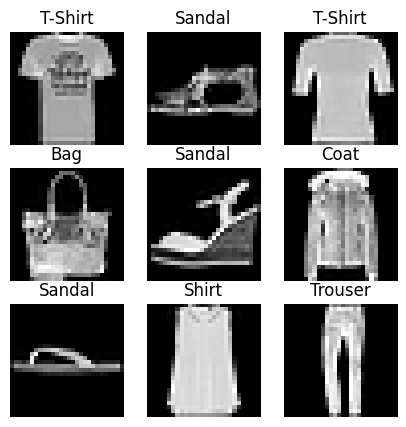

In [17]:
import matplotlib.pyplot as plt
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [18]:
# Preparing data with Data Loaders

train_dataloader = DataLoader(training_data, batch_size=64) # The DataLoader class is used to wrap the training dataset, allowing for easy batching and shuffling.
test_dataloader = DataLoader(test_data, batch_size=64) # The DataLoader class is used to wrap the test dataset, allowing for easy batching and shuffling.

In [19]:
# Iterating through the data loader

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

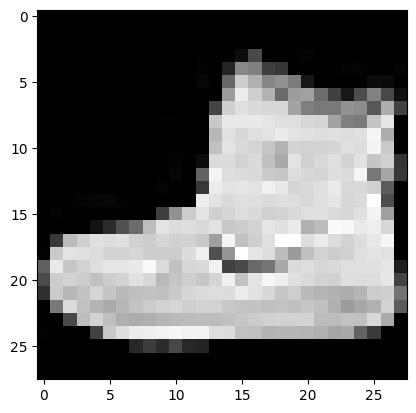

Label: 9


In [20]:
# Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively).
#Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at Samplers).

train_features, train_labels = next(iter(train_dataloader)) # This means that 'DataLoader' function returns two values: train_features and train_labels
print(train_features)
print(train_labels)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

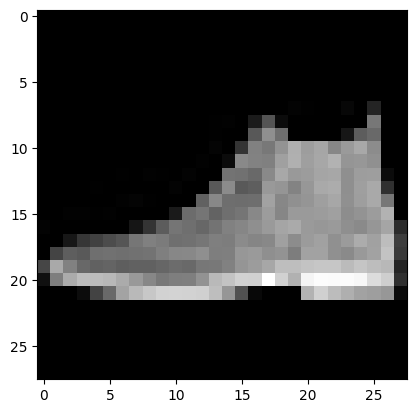

Label: 9


In [21]:
test_features, test_labels = next(iter(test_dataloader)) # This means that 'DataLoader' function returns two values: 'train_features' and 'train_labels'
print(test_features)
print(test_labels)
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
label = test_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Building the Neural Network

In [22]:
# Variational Autoencoder Definition
class VAE(nn.Module): # 'VAE' inherits from 'nn.Module', which is the base class for all neural network modules in PyTorch.
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400) # The encoder part of the VAE consists of two fully connected (Linear) layers that map the input image (flattened to 28*28 pixels) to a hidden layer of size 400.
                                         # the flattening of the input image is done implicitly within the forward method of the VAE class instead of using a separate flatten method or layer.
        # From this hidden layer, two separate fully connected layers (fc21 and fc22) output the mean and logarithm of variance for the latent space, respectively.
        self.fc21 = nn.Linear(400, 20)  # Mean vector
        self.fc22 = nn.Linear(400, 20)  # Variance vector (log_var)

        # decoder
        self.fc3 = nn.Linear(20, 400) # The decoder part consists of two fully connected layers that aim to reconstruct the image from the latent space representation.
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x): # The encode function applies a ReLU activation to the output of the first layer, then it outputs the parameters for the latent distribution.
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar): # reparameterize is a trick to allow backpropagation through random sampling. It adds a random element eps scaled by the standard deviation (std) to the mean mu.
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z): # The decode function attempts to reconstruct the input data from the latent variable z.
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x): # The forward method ties everything together.
                          # It takes an input tensor x, computes the mu and logvar, then samples a z from the latent distribution, and finally returns the reconstructed input, as well as the mu and logvar for loss calculation.
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Instantiate the model

In [23]:
# Instantiate the model
model = VAE() # This line creates an instance of the VAE class, which we have defined previously.

In [24]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    # KL divergence regularization term.
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

BCE - Binary Cross Entropy loss:
- recon_x is the reconstructed output from the VAE after passing the input x through the encoder and then the decoder.
- x.view(-1, 28*28) flattens the input images to match the shape of recon_x. This is necessary because recon_x is the output of the decoder which is a vector that represents the flattened image.
The binary cross entropy loss measures the pixel-wise difference between the original and reconstructed images, treating each pixel as an independent Bernoulli distribution (which is a reasonable assumption for grayscale images after applying a sigmoid activation).
- The reduction='sum' argument means that the BCE loss will be summed over all elements of the batch, rather than averaged.

KLD - Kullback-Leibler Divergence loss:
- This is a measure of how one probability distribution diverges from a second, expected probability distribution. For VAEs, it's used to regularize the encoder by comparing the distribution of latent variables it produces (described by mu and logvar) to a standard normal distribution.
- logvar represents the logarithm of the variance of the latent distribution, and mu represents the mean of the latent distribution.
- The formula -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) computes the KL divergence loss for a normal distribution, which can be derived from the analytical solution for the KL divergence between two Gaussian distributions.

The loss function returns the sum of the BCE and KLD terms. The BCE term encourages the reconstruction to match the original data, while the KLD term encourages the latent variables to follow a standard normal distribution, thereby ensuring a well-formed latent space

In [25]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

This line creates an optimizer that will be used to update the weights of the model.
- torch.optim.Adam: This specifies that we're using the Adam optimization algorithm. Adam is an adaptive learning rate optimization algorithm that's widely used in training deep neural networks because it combines the advantages of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).
- model.parameters(): This is a generator that returns an iterator over all variables (weights and biases) in the model that require a gradient. These are the parameters that will be updated by the optimizer.
- lr=1e-3: The learning rate (lr) is set to 0.001. The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the right learning rate is crucial as it can make the model converge too slowly or cause it to oscillate around or diverge from the minimum loss.

So, this line initializes the Adam optimizer with a learning rate of 0.001 to train the VAE. During training, this optimizer will be used to apply the gradients computed via backpropagation to adjust the model's weights with the aim of minimizing the loss function.

In [27]:
# Training Loop
def train_loop(dataloader, model, loss_fn, optimizer): # This line defines a function named train_loop that takes four parameters:
                                                       # dataloader: Provides batches of data from the training set.
                                                       # model: The VAE model to be trained.
                                                       # loss_fn: The loss function to use, which in the case of a VAE, usually combines reconstruction loss with KL divergence.
                                                       # optimizer: The optimization algorithm to adjust model parameters.
    model.train() # Before starting the loop, we set the model to training mode.
                  # This is important because some models may use mechanisms like dropout or batch normalization that have distinct behaviors during training versus evaluation (testing).
    train_loss = 0 # Initialize loss accumulator - This initializes a variable to accumulate the loss over all batches. This will be used to calculate the average loss at the end of the epoch.
    for batch_idx, (data, _) in enumerate(dataloader): # Training loop over batches - This starts a loop over the dataloader, providing a batch index (batch_idx) and data
                                                       # Each data item is a batch of images, and the _ is a placeholder for the labels, which are not needed for training an autoencoder.
        optimizer.zero_grad() # Zero the parameter gradients - This resets all gradients in the model parameters before calculating the new gradients for the current batch.
                              # If this step is skipped, gradients would accumulate across batches, which is not the desired behavior for most training scenarios.
        recon_batch, mu, logvar = model(data) # Forward pass - This line runs a forward pass of the data through the model. The model returns the reconstructed batch, the mean mu, and the log variance logvar of the latent variables.
        loss = loss_fn(recon_batch, data, mu, logvar) # Loss computation - The loss_fn is called with the model's output and the original data to compute the loss for the batch.
                                                      # The function combines the reconstruction loss and the KL divergence loss.
        loss.backward() # Backward pass - This computes the gradient of the loss with respect to the model parameters by backpropagation.
        train_loss += loss.item() # Accumulate loss - Here, we add up the scalar loss of the current batch to the total train_loss for later calculation of the average loss.
        optimizer.step() # Parameter update - This line updates the model parameters based on the gradients computed during .backward().

        if batch_idx % 100 == 0: # Logging - This conditional statement checks if the batch index is a multiple of 100.
                                 # If it is, it logs the current loss averaged over the data in the batch. This provides feedback on the training progress.
            print(f"Train Epoch: {batch_idx} Loss: {loss.item() / len(data):.6f}")

    print(f"====> Epoch: Train loss: {train_loss / len(dataloader.dataset):.6f}") # After all batches are processed, this line prints the average loss over the entire dataset.
                                                                                  # The total train_loss is divided by the number of samples in the dataset (len(dataloader.dataset)) to get the average loss per sample.

In [28]:
# Testing Loop
def test_loop(dataloader, model, loss_fn): # This line defines a function called test_loop that will be used to evaluate the model's performance on the test dataset. The function takes three parameters:
                                           # dataloader: An iterator that provides batches of data from the test dataset.
                                           # model: The VAE model that has been trained and will now be evaluated.
                                           # loss_fn: The loss function that the model will be evaluated against.
    model.eval() # This sets the model to evaluation mode. It's necessary because some models may use layers such as dropout or batch normalization which behave differently during training than during testing.
    test_loss = 0 # Initialize Loss Accumulator - This initializes a variable to accumulate the total loss across all test data batches.
    with torch.no_grad(): # Disable gradient calculations - This context manager tells PyTorch that no gradients should be calculated for the operations performed inside the block.
                          # This is important during testing because it reduces memory consumption and increases computation speed since gradients are not needed.
        for data, _ in dataloader: # Test Loop Over Batches - This loops over each batch in the dataloader.
                                   # Here data contains the input images and _ is a placeholder for labels which are not used during the testing of an autoencoder.
            recon_batch, mu, logvar = model(data) # Model Forward Pass - Within the loop, we pass the data through the model to get the reconstructed batch...
                                                  # ...as well as the mu and logvar that represent the mean and logarithm of the variance of the latent distribution, respectively.
            test_loss += loss_fn(recon_batch, data, mu, logvar).item() # Here, we compute the loss for the current batch using the loss_fn, which is typically the same loss function used during training...
                                                                       # ...combining reconstruction error and KL divergence.
                                                                       # We add the loss for the current batch to the total test_loss. The .item() method is used to get the scalar value of the loss tensor.

    test_loss /= len(dataloader.dataset)
    print(f"====> Test set loss: {test_loss:.6f}")

In [ ]:
# Train the VAE
epochs = 10
for epoch in range(1, epochs + 1):
    train_loop(train_dataloader, model, loss_function, optimizer)

In [10]:
test_loop(test_dataloader, model, loss_function)

====> Test set loss: 243.320911
